## Import dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('../data/responseFile_1.csv')

## Create Continous data from discrete data
We will try to create continous data from discrete data. We will use the following approach:
- We start with an average attentive value of 0.5. In future experiments this needs to be the the average attentiveness of the test taker. They can tell a value between 0.2 and 0.8.
- We then increase attention on correct answers and decrease attention on wrong answers.

In [3]:
df.head()

,Elapsed Time (ms),Response Time (ms),Alphabet,Correct,Error Type,Pitch,Yaw,Roll
0,1267,1267,P,Yes,None,359.6631,184.4655,355.5853
1,3334,1322,O,Yes,None,357.3612,176.5136,356.9228
2,4805,790,N,Yes,None,355.9378,185.2690,356.4589
3,6994,971,C,Yes,None,354.7144,167.1992,355.7530
4,8762,738,P,Yes,None,357.5221,185.2620,353.8421


In [4]:
global_attentive = 0.5
# if correct us yes increase attention by 0.1 else decrease by 0.1
for index, row in df.iterrows():
    if row[' Correct'] == ' Yes':
        global_attentive = min(0.8, global_attentive * 1.1)
    else:
        global_attentive = max(0.2, global_attentive * 0.5)
    df.at[index, 'attentive'] = global_attentive

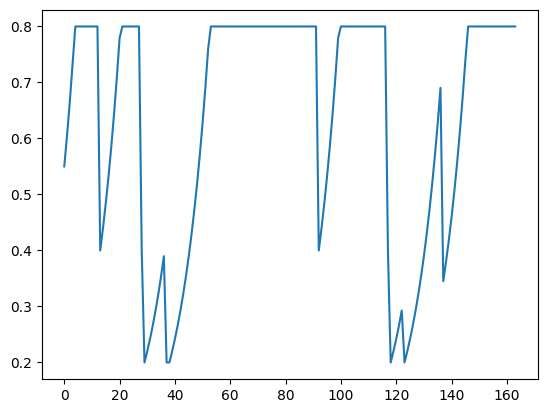

In [5]:
plt.plot(df.attentive)

## Adjusted function for continous data

In [6]:

def adjust_values_with_improved_logic(df, bool_col_name, start_value=0.5):
    """
    Adjusts a running value based on boolean values in a DataFrame column,
    with more significance given to False values and preventing values from
    getting stuck at 0.9 due to predominant True values.
    
    Parameters:
    - df: pandas DataFrame containing the boolean column.
    - bool_col_name: the name of the column with boolean values.
    - start_value: the starting value for the adjustment process.
    
    Returns:
    - A list of adjusted values with more complex adjustments.
    """
    current_value = start_value
    adjusted_values = []
    prev_bool = None
    
    # below are hyperparameters that can be tuned
    consecutive_count = 1
    increase_factor = 0.1
    decrease_factor = 0.3

    # Iterate through each row in the DataFrame
    for idx, row in df.iterrows():
        current_bool = True if row[bool_col_name] == ' Yes' else False
        if current_bool == prev_bool:
            consecutive_count += 1
        else:
            consecutive_count = 1  # Reset count if the sequence breaks
        
        if current_bool:
            # Apply a non-linear increase based on the distance from the upper bound
            increment = increase_factor * (0.9 - current_value) * np.sqrt(consecutive_count)
            current_value += min(increment, 0.9 - current_value)
        else:
            # Apply a more aggressive and non-linear decrease for False values
            decrement = decrease_factor * (current_value - 0.1) * np.sqrt(consecutive_count)
            current_value -= min(decrement, current_value - 0.1)
        
        # Ensure current_value stays within bounds
        current_value = max(0.1, min(0.9, current_value))
        adjusted_values.append(current_value)
        
        prev_bool = current_bool
    
    return adjusted_values


In [7]:
import pandas as pd

# Define or import your adjust_values_with_improved_logic function here

# List of file paths
file_paths = [
    '../data/responseFile_1.csv',
    '../data/responseFile_3.csv',
    '../data/responseFile_4.csv',
    '../data/responseFile_5.csv',
    '../data/responseFile_6.csv',
    '../data/responseFile_7.csv',
    '../data/responseFile_8.csv',
    '../data/responseFile_9.csv',
    '../data/responseFile_10.csv',
    # '../data/responseFile_11.csv',
    '../data/responseFile_12.csv',
    '../data/responseFile_13.csv',
    '../data/responseFile_14.csv',
    '../data/responseFile_15.csv',
    '../data/responseFile_16.csv',
    '../data/responseFile_17.csv',
]

# Initialize an empty list to store DataFrames
dfs = []

# Loop through each file path
for file_path in file_paths:
    # Read the current CSV file
    df = pd.read_csv(file_path)
    
    # Apply the function to adjust 'attention' based on 'Correct' column
    df['attention'] = adjust_values_with_improved_logic(df, ' Correct', start_value=0.5)
    
    # Append the processed DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames in the list into one
combined_df = pd.concat(dfs, ignore_index=True)

# Now combined_df contains all data processed and combined

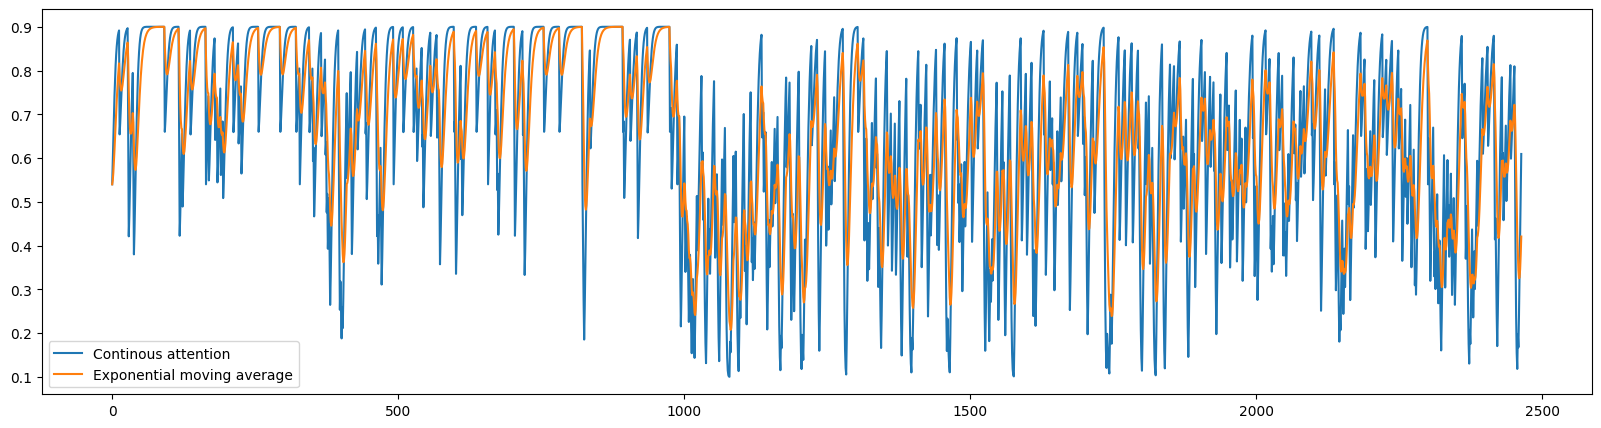

In [8]:
plt.figure(figsize=(20, 5))
combined_df['attention_old'] = combined_df['attention']
combined_df['attention'] = combined_df['attention'].ewm(span=10, adjust=False).mean()
plt.plot(combined_df.attention_old, label='Continous attention')
plt.plot(combined_df.attention, label='Exponential moving average')
plt.legend()

In [9]:
# Normalize the values of 'Pitch', 'Roll', and 'Yaw' columns
combined_df[' Pitch'] = round(((combined_df[' Pitch'] + 180) % 360), 2)
combined_df[' Roll'] = round(((combined_df[' Roll'] + 180) % 360), 2)
features = combined_df[[' Pitch', ' Roll', ' Yaw']]
labels = combined_df['attention']

## Random Forrest regressor

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler((0,1))
features_scaled = sc.fit_transform(features)


# Split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [11]:
# fit a random forrest regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

regr = RandomForestRegressor(500, random_state=0, max_depth=25)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

In [12]:
print('Results for Random Forrest Regressor')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test, y_pred)*100:.2f}%')

Results for Random Forrest Regressor
Mean Absolute Percentage Error: 18.07%


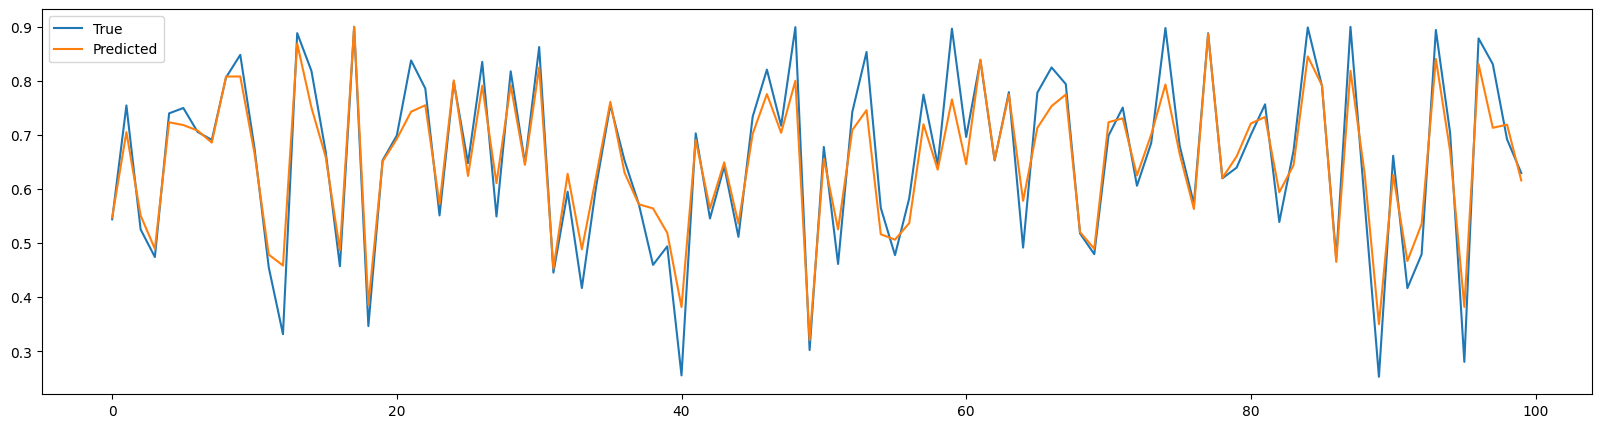

In [13]:
train_preds = regr.predict(X_train[:100])
plt.figure(figsize=(20, 5))
plt.plot(y_train.values[:100], label='True')
plt.plot(train_preds, label='Predicted')
plt.legend()

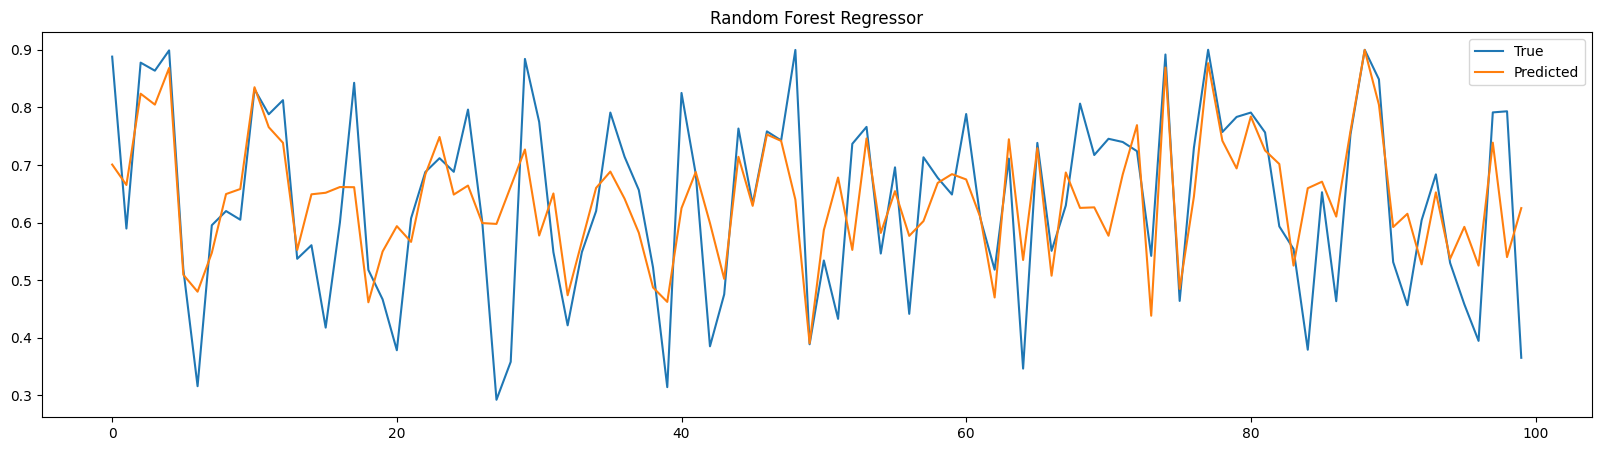

In [14]:
plt.figure(figsize=(20, 5))
plt.plot(y_test.values[:100], label='True')
plt.plot(y_pred[:100], label='Predicted')
plt.title('Random Forest Regressor')
plt.legend()

In [53]:
# save rancom forest model
import joblib
joblib.dump(regr, '../models/random_forest_regressor.joblib')

['../models/random_forest_regressor.joblib']

Optimal threshold: 0.6000000000000002


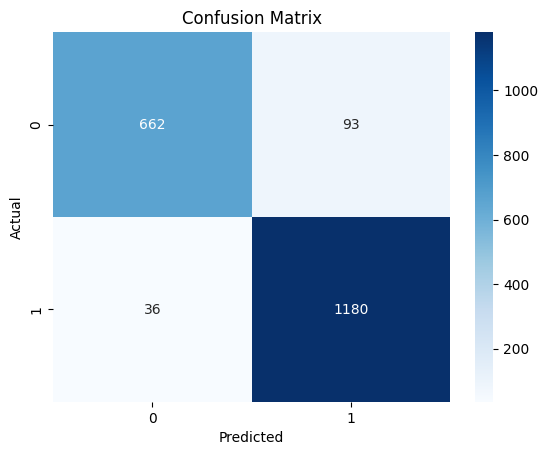

In [23]:
from sklearn.metrics import f1_score

# Assuming regr, X_train, and y_train are defined
train_preds = regr.predict(X_train)

# Define a range of thresholds to test
thresholds = np.arange(0.1, 0.7, 0.05)

# Function to calculate F1 score for each threshold
def get_f1_for_threshold(threshold):
    train_preds_binary = train_preds > threshold
    y_train_binary = y_train > threshold
    return f1_score(y_train_binary, train_preds_binary)

# Calculate F1 scores for all thresholds
f1_scores = [get_f1_for_threshold(t) for t in thresholds]

# Find the threshold that maximizes the F1 score
optimal_threshold = thresholds[np.argmin(f1_scores)]
print(f'Optimal threshold: {optimal_threshold}')

# Use the optimal threshold to create binary predictions
train_preds_binary = train_preds > optimal_threshold
y_train_binary = y_train > optimal_threshold

# Calculate confusion matrix
cm = confusion_matrix(y_train_binary, train_preds_binary)

# Create a heatmap with whole number annotations
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Set labels and title for better readability
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

So in our final model we will use 0.6 as the threshold to separate attentive and non attentive

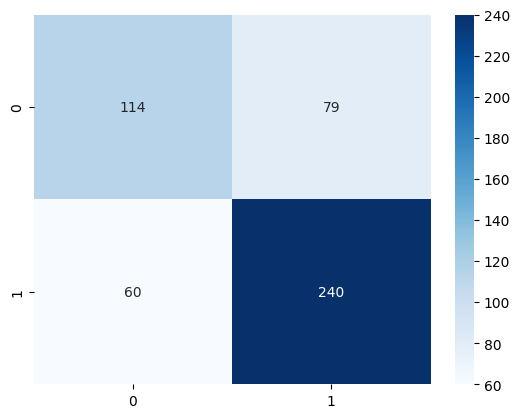

In [26]:
y_pred_binary = y_pred > optimal_threshold
y_test_binary = y_test > optimal_threshold
cm = confusion_matrix(y_test_binary, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [28]:
from keras.utils import timeseries_dataset_from_array

gen = timeseries_dataset_from_array(np.asarray(features), np.asarray(labels), 10, batch_size=10000000)

In [29]:
x , y = next(iter(gen))
x.shape, y.shape

(TensorShape([2455, 10, 3]), TensorShape([2455]))

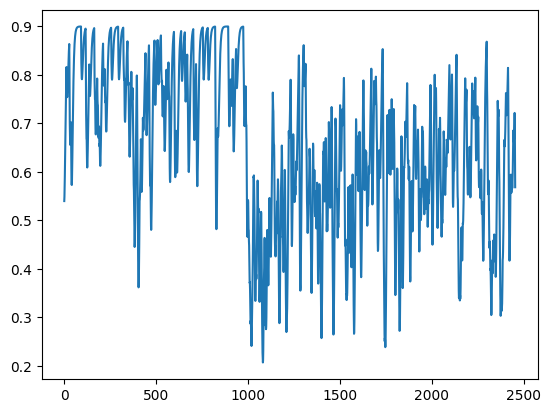

In [30]:
plt.plot(y)

In [31]:
# train test split
train_data = x[:int(len(x) * 0.8)]
train_labels = y[:int(len(y) * 0.8)]
val_data = x[int(len(x) * 0.8):]
val_labels = y[int(len(y) * 0.8):]

In [141]:
import tensorflow as tf
# Assuming stacked_features is already defined and available.
# stacked_features.shape[2] should represent the number of features in each input sequence.

# Define the input layer with the shape (10, number of features)
input_layer = tf.keras.layers.Input(shape=(10, 3))

# Define a stack of LSTM layers in a sequential fashion
lstm_layer1 = tf.keras.layers.LSTM(128, return_sequences=True, activation='tanh', recurrent_dropout=0.4, dropout=0)(input_layer)
lstm_layer2 = tf.keras.layers.LSTM(32, activation='tanh', recurrent_dropout=0.4, dropout=0)(lstm_layer1)

# Define the output layer
hidden_layer = tf.keras.layers.Dense(512, activation='relu')(lstm_layer2)
droput_layer = tf.keras.layers.Dropout(0.5)(hidden_layer)
hidden_layer2 = tf.keras.layers.Dense(1024, activation='relu')(droput_layer)
droput_layer2 = tf.keras.layers.Dropout(0.5)(hidden_layer2)
hidden_layer3 = tf.keras.layers.Dense(128, activation='relu')(droput_layer2)
droput_layer3 = tf.keras.layers.Dropout(0.5)(hidden_layer3)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(droput_layer3)

# Create the sequential model
sequential_model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

sequential_model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 10, 3)]           0         
                                                                 
 lstm_21 (LSTM)              (None, 10, 128)           67584     
                                                                 
 lstm_22 (LSTM)              (None, 32)                20608     
                                                                 
 dense_38 (Dense)            (None, 512)               16896     
                                                                 
 dropout_26 (Dropout)        (None, 512)               0         
                                                                 
 dense_39 (Dense)            (None, 1024)              525312    
                                                                 
 dropout_27 (Dropout)        (None, 1024)              0  

In [ ]:
# Compile the model
sequential_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000003),
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
)

base_history = sequential_model.fit(
    train_data, train_labels,
    epochs=1000,
    batch_size=128,
    validation_data=(val_data, val_labels),
    verbose=1,
)

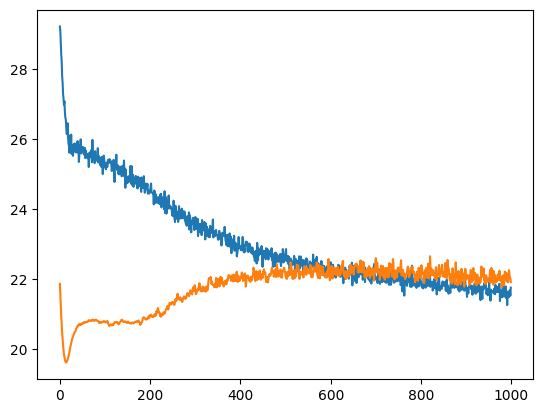

In [143]:
plt.plot(base_history.history['loss'], label='loss')
plt.plot(base_history.history['val_loss'], label='val_loss')

62/62 [==============================] - 1s 4ms/step


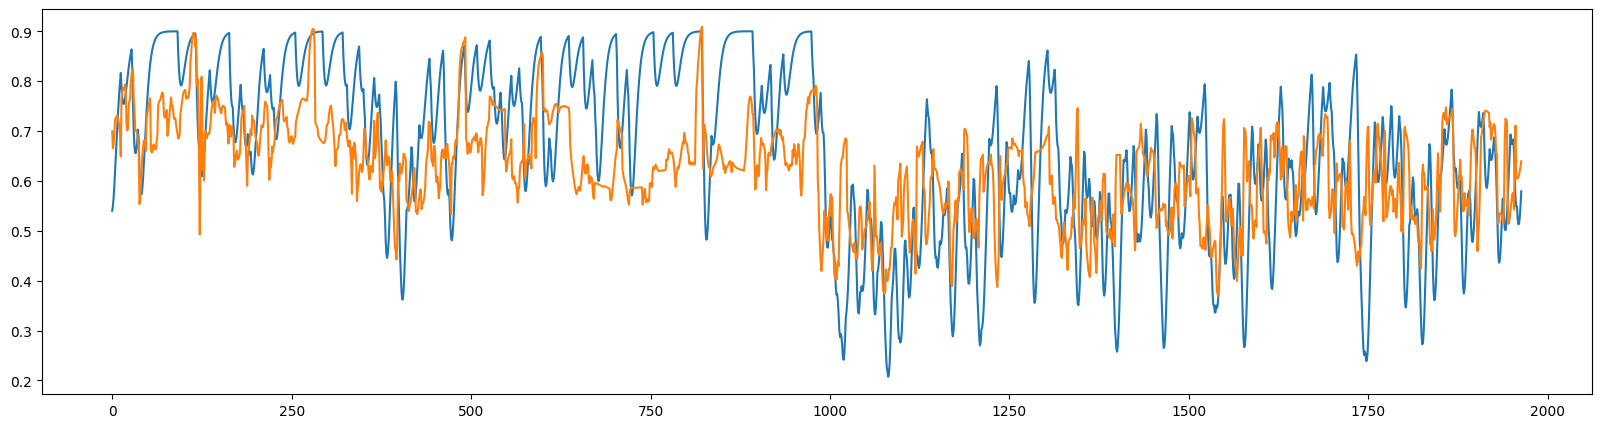

In [144]:
plt.figure(figsize=(20, 5))
plt.plot(train_labels, label='True')
plt.plot(sequential_model.predict(train_data), label='Predicted')

16/16 [==============================] - 0s 5ms/step


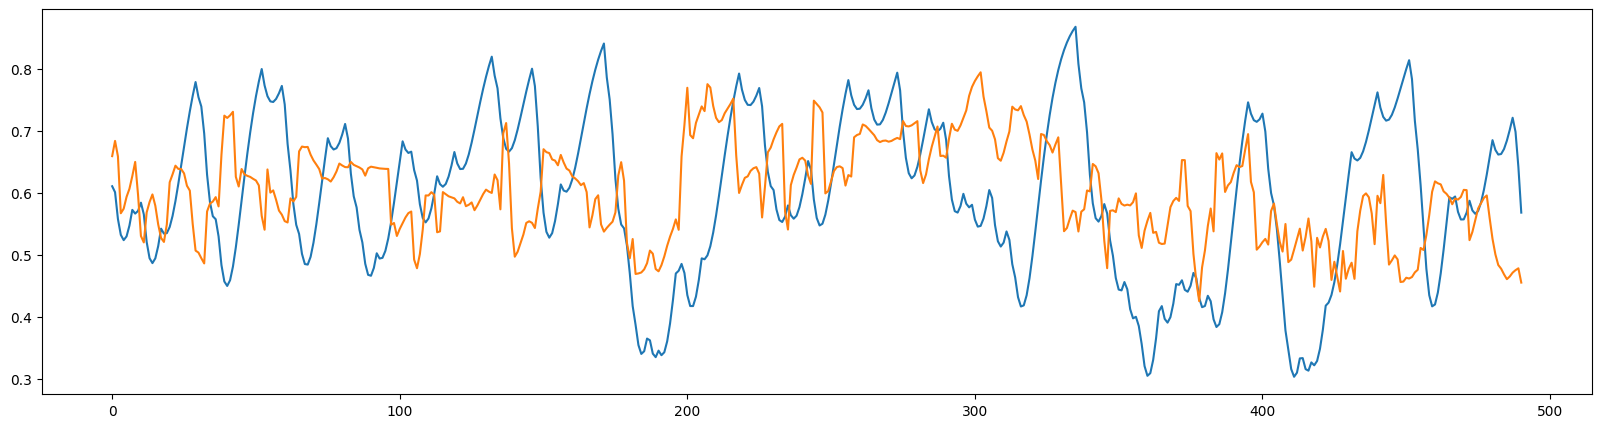

In [145]:
plt.figure(figsize=(20, 5))
plt.plot(val_labels)
plt.plot(sequential_model.predict(val_data))

62/62 [==============================] - 0s 4ms/step


<Axes: >

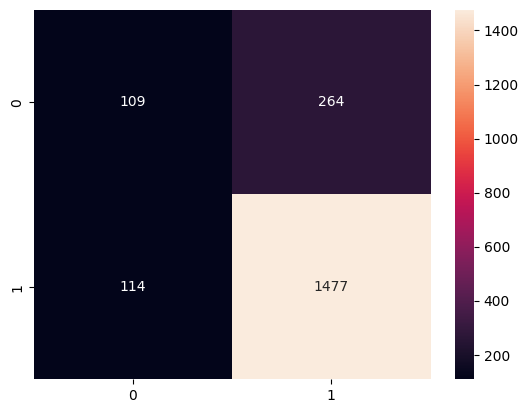

In [146]:
y_pred = sequential_model.predict(train_data)
y_pred_binary = y_pred > 0.5
y_test_binary = train_labels > 0.5
cm = confusion_matrix(y_test_binary, y_pred_binary)
sns.heatmap(cm, annot=True, fmt="d")


16/16 [==============================] - 0s 4ms/step


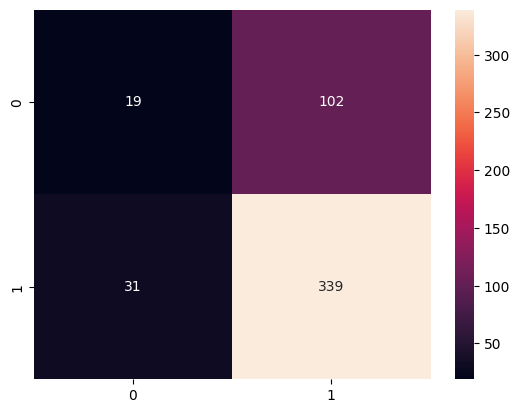

In [147]:
y_pred = sequential_model.predict(val_data)
y_pred_binary = y_pred > 0.5
y_test_binary = val_labels > 0.5
cm = confusion_matrix(y_test_binary, y_pred_binary)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()


In [158]:
preds = sequential_model(train_data)
val_preds = sequential_model(val_data)

In [159]:
print('Results for LSTM')
print(f'Train data Mean Absolute Percentage Error: {mean_absolute_percentage_error(train_labels, preds)*100:.2f}%')
print(f'Validation data Mean Absolute Percentage Error: {mean_absolute_percentage_error(val_labels, val_preds)*100:.2f}%')

Results for LSTM
Train data Mean Absolute Percentage Error: 20.90%
Validation data Mean Absolute Percentage Error: 21.92%


In [140]:
from datetime import datetime

time = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
unique_file_name = '../models/LSTM-' + time + '.h5'
sequential_model.save(unique_file_name)

c:\Users\muham\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
